In [134]:
import pandas as pd  # For data manipulation
import numpy as np  # For numerical computations
import matplotlib.pyplot as plt  # For visualization
import seaborn as sns  # For statistical plotting
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans  # K-Means Clustering
from sklearn.metrics import silhouette_score  # Evaluate clustering quality

In [45]:
#Read the datasets
customer_feedback_data = pd.read_csv(r"C:\Users\kuros\OneDrive\Desktop\customer_feedback_data_cleaned.csv")  # Load customer feedback
transaction_data = pd.read_csv(r"C:\Users\kuros\OneDrive\Desktop\transaction_data_cleaned.csv")  # Load transaction data
product_offering_data = pd.read_csv(r"C:\Users\kuros\OneDrive\Desktop\product_offering_data_cleaned.csv")  # Load transaction data

In [83]:
# Check basic info
print(customer_feedback_data.info())
print(transaction_data.info())
print(product_offering_data.info())

# Display the first few rows
print(customer_feedback_data.head())
print(transaction_data.head())
print(product_offering_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4969 entries, 0 to 4968
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Customer_ID                     4969 non-null   int64  
 1   Satisfaction_Score_Scaled       4969 non-null   float64
 2   Likelihood_to_Recommend_Scaled  4969 non-null   float64
 3   Feedback_Comments_Encoded       4969 non-null   int64  
 4   Cluster                         4969 non-null   int32  
 5   Cluster_DBSCAN                  4969 non-null   int64  
 6   Cluster_KMeans2                 4969 non-null   int32  
 7   Cluster_K2                      4969 non-null   int32  
dtypes: float64(2), int32(3), int64(3)
memory usage: 252.5 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  

In [85]:
# Check for duplicates
print("Customer Feedback Duplicates:", customer_feedback_data.duplicated().sum())
print("Transaction Data Duplicates:", transaction_data.duplicated().sum())
print("Product Offering Duplicates:", product_offering_data.duplicated().sum())

Customer Feedback Duplicates: 2
Transaction Data Duplicates: 0
Product Offering Duplicates: 0


In [87]:
# Remove duplicates
customer_feedback_data = customer_feedback_data.drop_duplicates()

# Verify removal
print("Customer Feedback Duplicates After Cleaning:", customer_feedback_data.duplicated().sum())


Customer Feedback Duplicates After Cleaning: 0


In [89]:
# Function to detect outliers using IQR
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# Detect outliers in both numerical columns
outliers_satisfaction = detect_outliers_iqr(customer_feedback_data, 'Satisfaction_Score_Scaled')
outliers_likelihood = detect_outliers_iqr(customer_feedback_data, 'Likelihood_to_Recommend_Scaled')

# Print outliers count
print(f"Outliers in Satisfaction_Score_Scaled: {len(outliers_satisfaction)}")
print(f"Outliers in Likelihood_to_Recommend_Scaled: {len(outliers_likelihood)}")


Outliers in Satisfaction_Score_Scaled: 10
Outliers in Likelihood_to_Recommend_Scaled: 0


In [91]:
# Define the IQR boundaries
Q1 = customer_feedback_data["Satisfaction_Score_Scaled"].quantile(0.25)
Q3 = customer_feedback_data["Satisfaction_Score_Scaled"].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
customer_feedback_data_cleaned = customer_feedback_data[
    (customer_feedback_data["Satisfaction_Score_Scaled"] >= lower_bound) & 
    (customer_feedback_data["Satisfaction_Score_Scaled"] <= upper_bound)
]

# Print number of removed rows
print(f"Outliers removed: {customer_feedback_data.shape[0] - customer_feedback_data_cleaned.shape[0]}")

# Reset index
customer_feedback_data_cleaned.reset_index(drop=True, inplace=True)

Outliers removed: 10


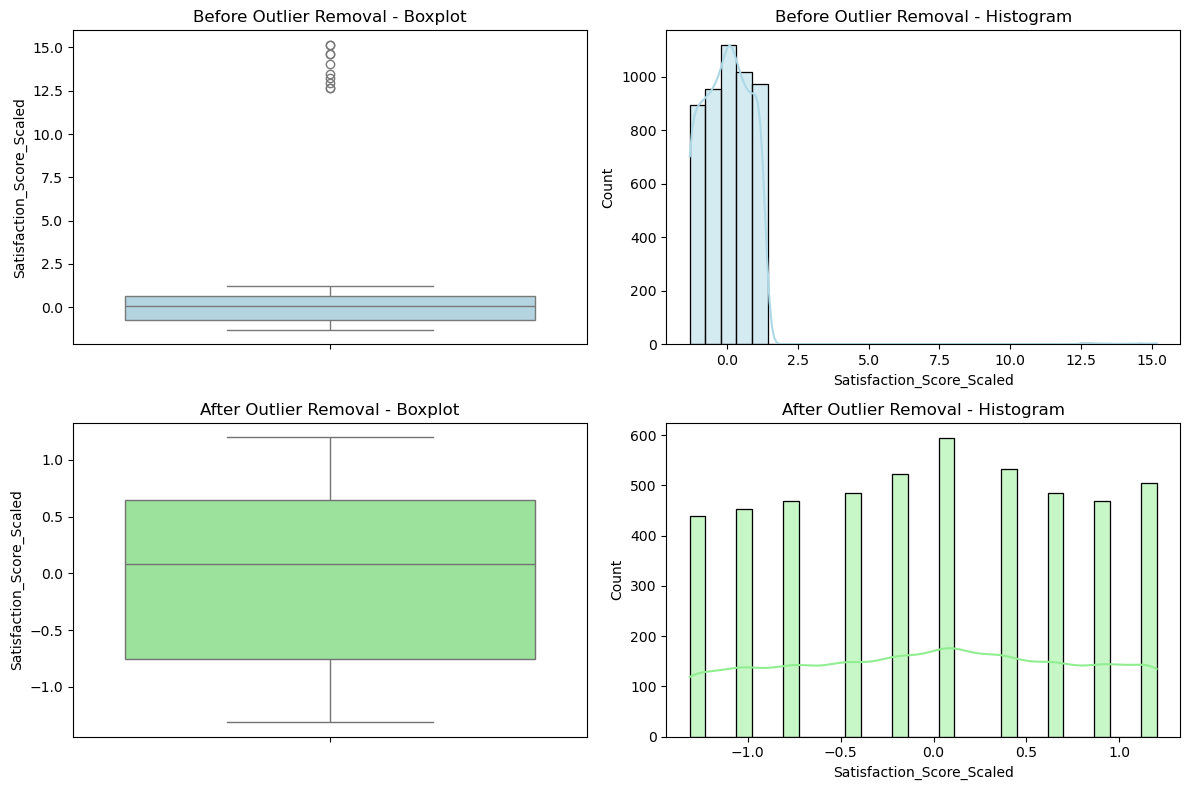

In [93]:
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Boxplot before outlier removal
sns.boxplot(y=customer_feedback_data["Satisfaction_Score_Scaled"], ax=axes[0, 0], color="lightblue")
axes[0, 0].set_title("Before Outlier Removal - Boxplot")

# Histogram before outlier removal
sns.histplot(customer_feedback_data["Satisfaction_Score_Scaled"], bins=30, kde=True, ax=axes[0, 1], color="lightblue")
axes[0, 1].set_title("Before Outlier Removal - Histogram")

# Boxplot after outlier removal
sns.boxplot(y=customer_feedback_data_cleaned["Satisfaction_Score_Scaled"], ax=axes[1, 0], color="lightgreen")
axes[1, 0].set_title("After Outlier Removal - Boxplot")

# Histogram after outlier removal
sns.histplot(customer_feedback_data_cleaned["Satisfaction_Score_Scaled"], bins=30, kde=True, ax=axes[1, 1], color="lightgreen")
axes[1, 1].set_title("After Outlier Removal - Histogram")

# Adjust layout
plt.tight_layout()
plt.show()

In [95]:
# Check for duplicates
transaction_duplicates = transaction_data.duplicated().sum()
print(f"Transaction Data Duplicates: {transaction_duplicates}")

# Check for missing values
transaction_missing = transaction_data.isnull().sum()
print("Missing Values in Transaction Data:\n", transaction_missing)

Transaction Data Duplicates: 0
Missing Values in Transaction Data:
 Transaction_ID               0
Customer_ID                  0
Transaction_Date             0
Transaction_Type             0
Transaction_Amount_Scaled    0
dtype: int64


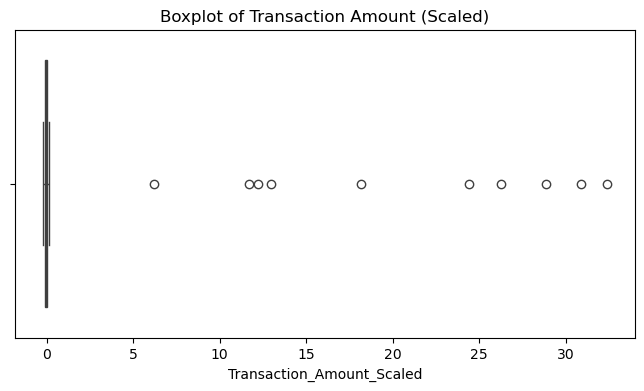

In [97]:
# Boxplot to check for outliers
plt.figure(figsize=(8, 4))
sns.boxplot(x=transaction_data["Transaction_Amount_Scaled"])
plt.title("Boxplot of Transaction Amount (Scaled)")
plt.show()

In [99]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = transaction_data["Transaction_Amount_Scaled"].quantile(0.25)
Q3 = transaction_data["Transaction_Amount_Scaled"].quantile(0.75)

# Compute IQR
IQR = Q3 - Q1

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Display boundaries
print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")


Lower Bound: -0.3713917272232615, Upper Bound: 0.285778986628314


In [101]:
# Filter out values outside the boundaries
filtered_transaction_data = transaction_data[
    (transaction_data["Transaction_Amount_Scaled"] >= lower_bound) &
    (transaction_data["Transaction_Amount_Scaled"] <= upper_bound)
]

# Display how many rows were removed
print(f"Original size: {transaction_data.shape[0]}, New size: {filtered_transaction_data.shape[0]}")


Original size: 5000, New size: 4990


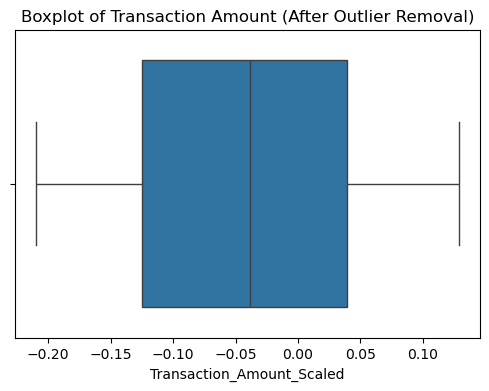

In [103]:
plt.figure(figsize=(6,4))
sns.boxplot(x=filtered_transaction_data["Transaction_Amount_Scaled"])
plt.title("Boxplot of Transaction Amount (After Outlier Removal)")
plt.show()

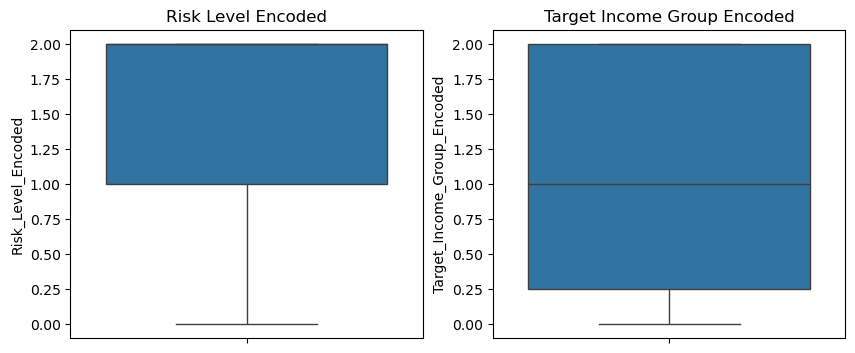

In [105]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
sns.boxplot(y=product_offering_data["Risk_Level_Encoded"])
plt.title("Risk Level Encoded")

plt.subplot(1,2,2)
sns.boxplot(y=product_offering_data["Target_Income_Group_Encoded"])
plt.title("Target Income Group Encoded")

plt.show()


In [116]:
customer_feedback_data['Cluster'].value_counts()

Cluster
1    1970
0    1507
2    1480
3      10
Name: count, dtype: int64

In [118]:
# Remove rows where Cluster == 3
customer_feedback_data = customer_feedback_data[customer_feedback_data['Cluster'] != 3]

# Reset index after removal
customer_feedback_data = customer_feedback_data.reset_index(drop=True)

# Verify new cluster distribution
print(customer_feedback_data['Cluster'].value_counts())

Cluster
1    1970
0    1507
2    1480
Name: count, dtype: int64


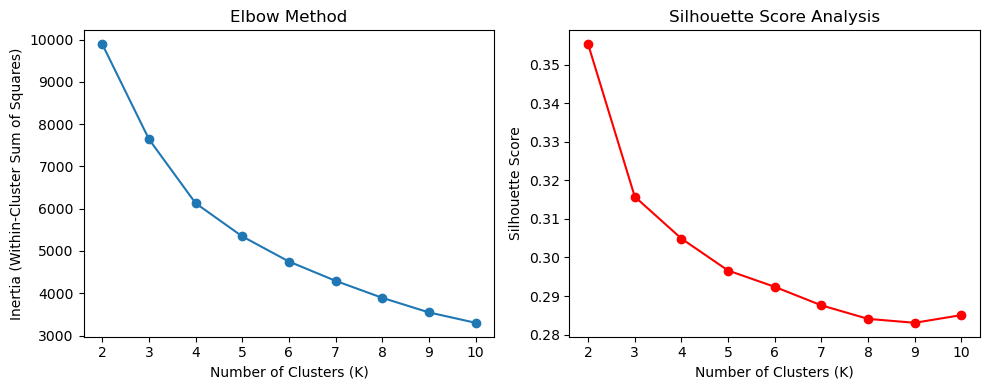

In [120]:
# Select features for clustering
X_feedback = customer_feedback_data[['Satisfaction_Score_Scaled', 'Likelihood_to_Recommend_Scaled', 'Feedback_Comments_Encoded']]

# Try different K values
inertia = []
silhouette_scores = []
K_values = range(2, 11)

for k in K_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_feedback)
    
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_feedback, clusters))

# Plot Elbow Method
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(K_values, inertia, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
plt.title("Elbow Method")

# Plot Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(K_values, silhouette_scores, marker='o', color='red')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score Analysis")

plt.tight_layout()
plt.show()

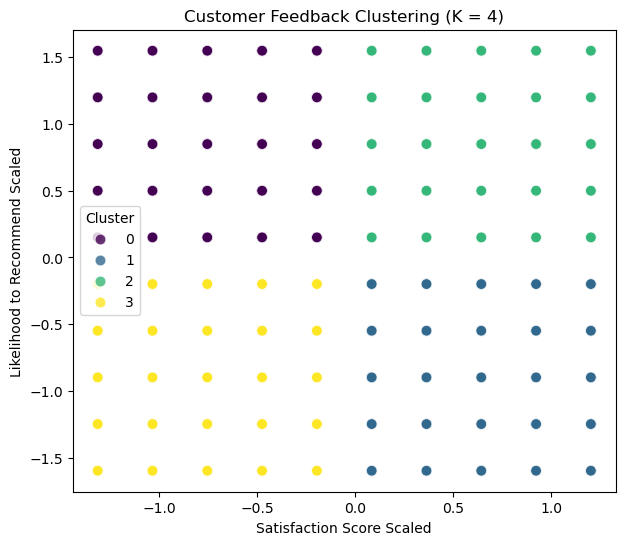

In [130]:
X = customer_feedback_data[['Satisfaction_Score_Scaled', 'Likelihood_to_Recommend_Scaled']]
k = 4  # Optimal number of clusters
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
customer_feedback_data['Cluster'] = kmeans.fit_predict(X)

# Step 5: Visualize the clusters
plt.figure(figsize=(7,6))
sns.scatterplot(
    x=customer_feedback_data['Satisfaction_Score_Scaled'], 
    y=customer_feedback_data['Likelihood_to_Recommend_Scaled'], 
    hue=customer_feedback_data['Cluster'], 
    palette="viridis", 
    s=60, 
    alpha=0.8
)
plt.title(f"Customer Feedback Clustering (K = {k})")
plt.xlabel("Satisfaction Score Scaled")
plt.ylabel("Likelihood to Recommend Scaled")
plt.legend(title="Cluster")
plt.show()

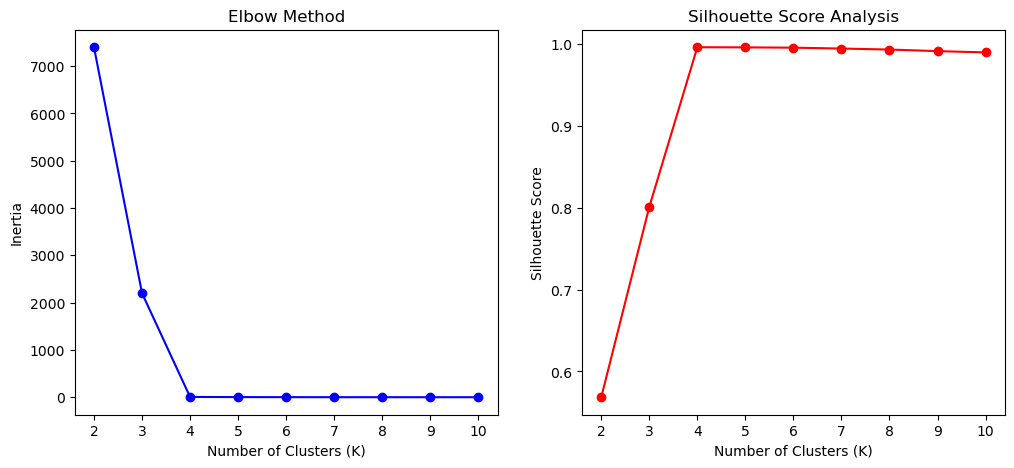

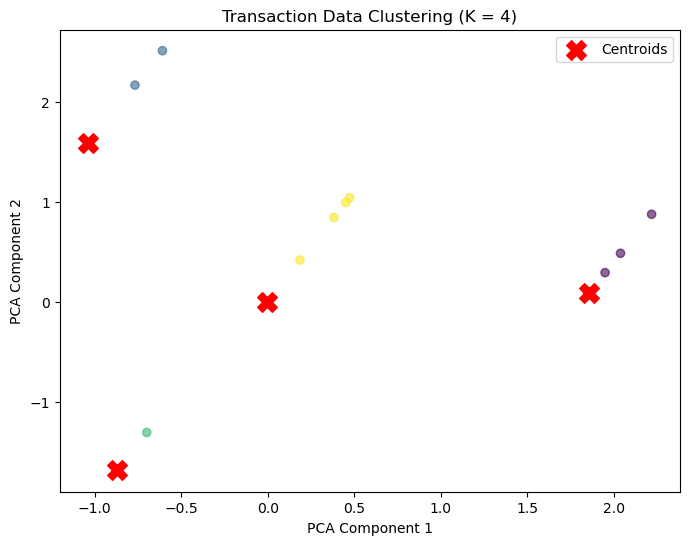

In [176]:
from sklearn.decomposition import PCA

# Step 1: Select relevant features
X = transaction_data[['Transaction_Amount_Scaled', 'Transaction_Type']].copy()

# Step 2: One-Hot Encode Transaction_Type
X = pd.get_dummies(X, columns=['Transaction_Type'], drop_first=True)

# Step 3: Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 4: Reduce dimensions using PCA
pca = PCA(n_components=2)  # Reduce to 2D for visualization
X_pca = pca.fit_transform(X_scaled)

# Step 5: Find optimal number of clusters (Elbow & Silhouette)
inertia = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_pca, kmeans.labels_))

# Step 6: Plot Elbow Method & Silhouette Score
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(K_range, inertia, marker='o', color='b')
ax[0].set_title("Elbow Method")
ax[0].set_xlabel("Number of Clusters (K)")
ax[0].set_ylabel("Inertia")

ax[1].plot(K_range, silhouette_scores, marker='o', color='r')
ax[1].set_title("Silhouette Score Analysis")
ax[1].set_xlabel("Number of Clusters (K)")
ax[1].set_ylabel("Silhouette Score")

plt.show()

# Step 7: Apply KMeans with optimal K
k_optimal = 4  # Adjust based on the elbow/silhouette analysis
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_pca)

# Step 8: Add cluster labels to dataframe
transaction_data['Cluster'] = clusters

# Step 9: Visualize clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, label="Centroids")
plt.title(f"Transaction Data Clustering (K = {k_optimal})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

In [178]:
product_offering_data

,Product_ID,Product_Name,Product_Type,Target_Income_Group,Risk_Level_Encoded,Target_Income_Group_Encoded
0,5,Auto Loan,Loan,Medium,2,2
1,9,Business Loan,Loan,Medium,2,2
2,2,Gold Savings Account,Savings Account,Low,1,1
3,3,High-Yield Investment Account,Investment,High,0,0
4,4,Mortgage Loan,Loan,High,2,0
5,6,Personal Loan,Loan,Low,2,1
6,1,Platinum Credit Card,Credit Card,Medium,2,2
7,8,Retirement Investment Fund,Investment,High,0,0
8,10,Travel Credit Card,Credit Card,Medium,2,2
9,7,Youth Savings Account,Savings Account,Low,1,1


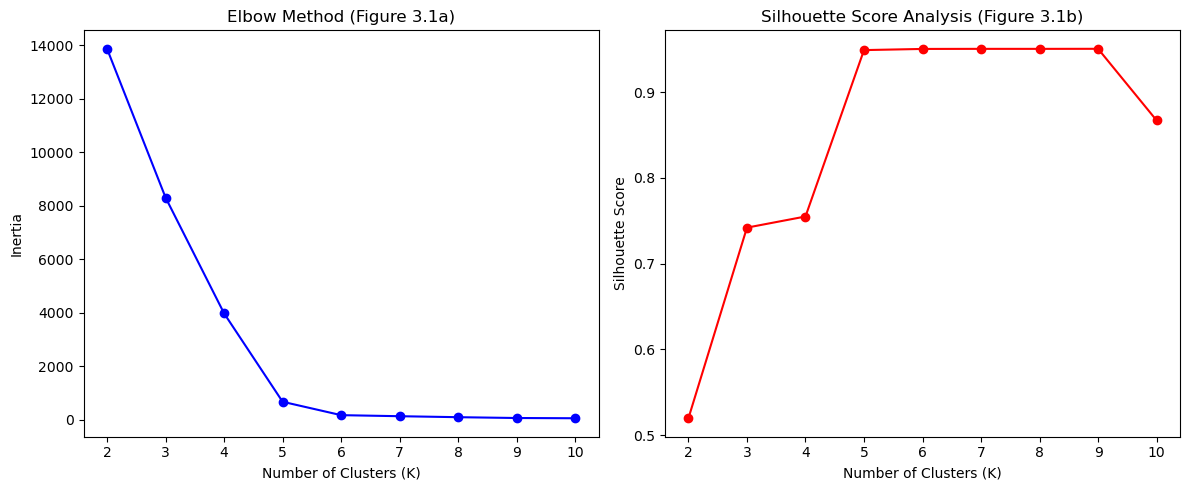

In [180]:
# Define range of K values
K_range = range(2, 11)
inertia = []
silhouette_scores = []

# Compute inertia & silhouette scores
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot Elbow Method & Silhouette Score
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Elbow Method
ax[0].plot(K_range, inertia, marker='o', color='b')
ax[0].set_title("Elbow Method (Figure 3.1a)")
ax[0].set_xlabel("Number of Clusters (K)")
ax[0].set_ylabel("Inertia")

# Silhouette Score
ax[1].plot(K_range, silhouette_scores, marker='o', color='r')
ax[1].set_title("Silhouette Score Analysis (Figure 3.1b)")
ax[1].set_xlabel("Number of Clusters (K)")
ax[1].set_ylabel("Silhouette Score")

plt.tight_layout()
plt.show()

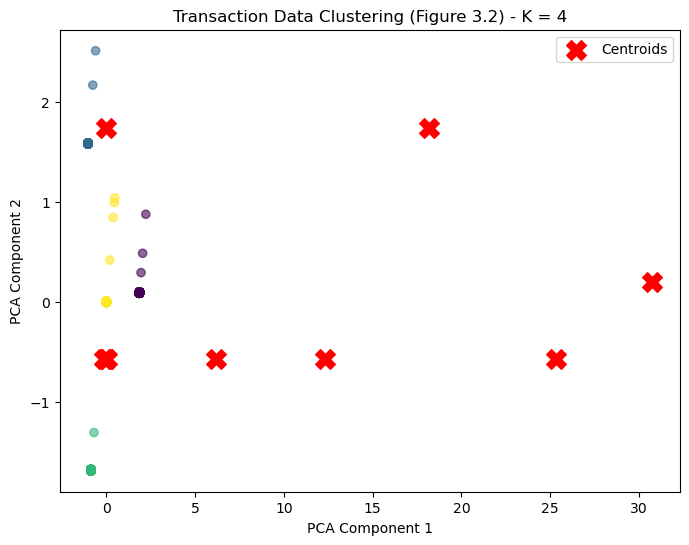

In [184]:
# Step 9: Visualize clusters (Figure 3.2)
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, label="Centroids")

# Titles & Labels
plt.title(f"Transaction Data Clustering (Figure 3.2) - K = {k_optimal}")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()

# Show plot
plt.show()


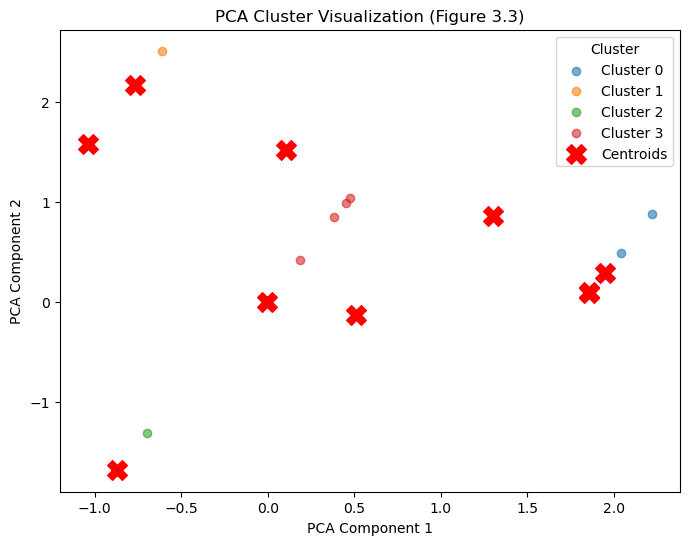

In [188]:
# Apply PCA to reduce dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Transform centroids to PCA space
centroids_pca = pca.transform(kmeans.cluster_centers_)

# Create a scatter plot with correct cluster labeling
plt.figure(figsize=(8, 6))

# Scatter plot of data points with assigned clusters
for cluster_id in range(k_optimal):
    cluster_points = X_pca[clusters == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id}", alpha=0.6)

# Mark centroids
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', marker='X', s=200, label="Centroids")

# Titles & Labels
plt.title("PCA Cluster Visualization (Figure 3.3)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")

# Show plot
plt.show()

C:\Users\kuros\AppData\Local\Temp\ipykernel_32840\4119730204.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=transaction_data['Cluster'], palette="viridis")


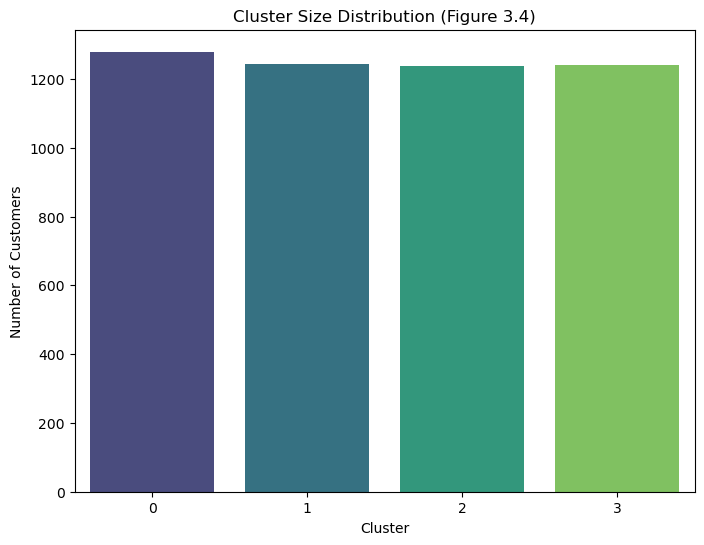

In [194]:
plt.figure(figsize=(8, 6))
sns.countplot(x=transaction_data['Cluster'], palette="viridis")

# Titles & Labels
plt.title("Cluster Size Distribution (Figure 3.4)")
plt.xlabel("Cluster")
plt.ylabel("Number of Customers")

plt.show()

C:\Users\kuros\AppData\Local\Temp\ipykernel_32840\3464598964.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=transaction_data['Cluster'], y=transaction_data['Transaction_Amount_Scaled'], palette='viridis')


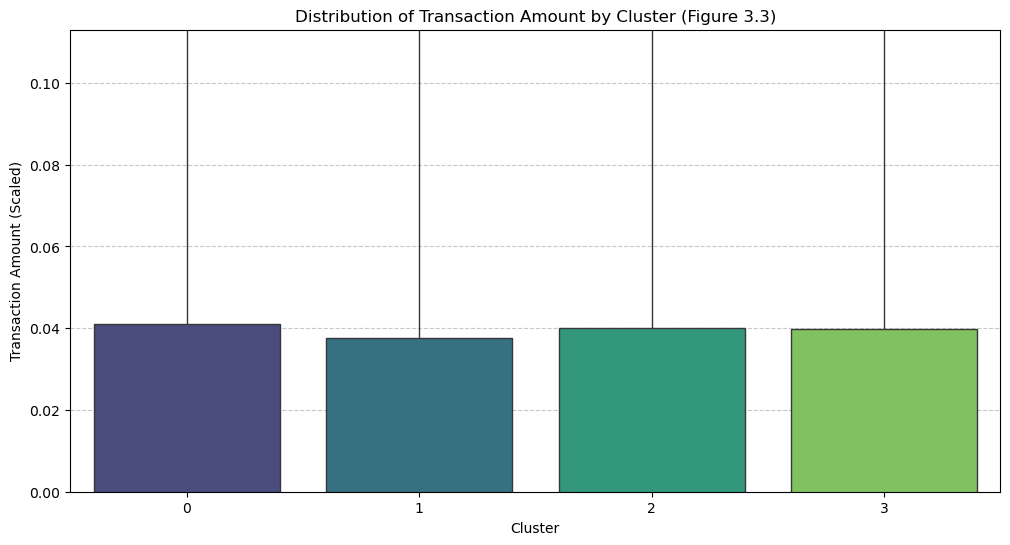

In [202]:
plt.figure(figsize=(12, 6))

# Adjusting y-scale for better visualization
sns.boxplot(x=transaction_data['Cluster'], y=transaction_data['Transaction_Amount_Scaled'], palette='viridis')

plt.ylim(0, np.percentile(transaction_data['Transaction_Amount_Scaled'], 95))  # Exclude extreme outliers
plt.title("Distribution of Transaction Amount by Cluster (Figure 3.3)")
plt.xlabel("Cluster")
plt.ylabel("Transaction Amount (Scaled)")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

C:\Users\kuros\AppData\Local\Temp\ipykernel_32840\2816256190.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=transaction_data['Cluster'], palette='viridis')


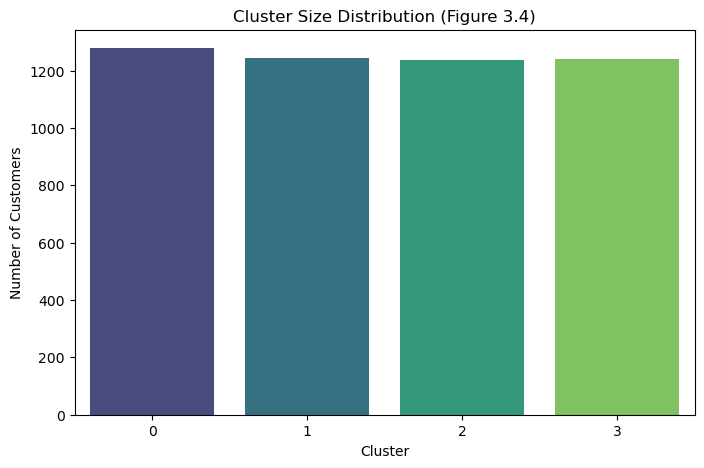

In [204]:
# Figure 3.6: Cluster Size Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x=transaction_data['Cluster'], palette='viridis')
plt.title("Cluster Size Distribution (Figure 3.4)")
plt.xlabel("Cluster")
plt.ylabel("Number of Customers")
plt.show()